# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use theppds to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between nodeppds and data generated by `world_dist`.

In [31]:
# import cProfile

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [32]:
nop.plot_setup()
cmap = "inferno"

In [33]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    # G=nx.empty_graph(1),
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=0,
        scale=10,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=1,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=50,  # End time of simulation
    t_sample=1,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    sampling=True,
    init_rngs=True,
)

In [34]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [35]:
# cProfile.run("nop.run_ConjMu(**input)")

In [36]:
# out1 = nop.run_ConjMu(**nop.input_ref_ConjMu)
out1 = nop.run_ConjMu(**input)

In [37]:
nop.export_hdf5(out1, "test.h5")
out1 = nop.import_hdf5("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [38]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
# plt.rcParams.update(
#    {
#        "font.size": 20,
#        "legend.loc": "upper right",
#    }
# )

#### Data analysis 1

Firstly, extract output values for further analysis:

In [39]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConjMu
mu_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 2.,  5.,  2.,  8., 13., 11., 15., 10.,  6., 10.,  5.,  5.,  3.,
         1.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([0.05832019, 0.06208512, 0.06585004, 0.06961497, 0.07337989,
        0.07714482, 0.08090974, 0.08467467, 0.08843959, 0.09220452,
        0.09596944, 0.09973437, 0.10349929, 0.10726422, 0.11102914,
        0.11479407, 0.11855899, 0.12232392, 0.12608884, 0.12985377,
        0.13361869]),
 <BarContainer object of 20 artists>)

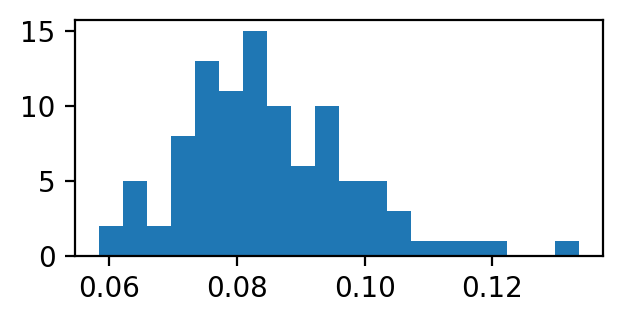

In [40]:
sigmas = []
for i in out1["nodesConjMu"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots()
ax.hist(sigmas, bins=20)

[[ 8.00406420e-01  8.00000000e+00  7.12848995e-01]
 [-1.62644095e+00  2.00000000e+00  9.41407369e-01]
 [ 1.24133198e+01  1.10000000e+01  1.05191669e+00]
 [ 2.40594514e+00 -1.00000000e+00  1.05551073e+00]
 [ 1.39575192e+00  8.40000000e+01  1.30192552e+00]
 [ 2.70442315e+00  1.10000000e+01  1.33308832e+00]
 [ 4.64915376e-01  8.00000000e+00  1.35024749e+00]
 [ 2.31171335e+00 -1.00000000e+00  3.47906326e+00]
 [ 3.17321540e+00  8.00000000e+00  3.73064246e+00]
 [ 1.44956643e-01 -1.00000000e+00  4.11877238e+00]
 [ 1.81294574e+00  1.10000000e+01  4.32890734e+00]
 [-8.31348294e-01  2.00000000e+00  5.77850721e+00]
 [ 1.31221039e+00 -1.00000000e+00  5.95325559e+00]
 [-4.44361809e-01 -1.00000000e+00  6.35176289e+00]
 [-1.10692828e+00  2.00000000e+00  6.60033162e+00]
 [-1.24234035e-01 -1.00000000e+00  7.48748943e+00]
 [ 2.76116510e+00 -1.00000000e+00  7.54137598e+00]
 [ 1.50114167e-01  2.00000000e+00  7.69679779e+00]
 [-4.26528819e-01  3.10000000e+01  7.86408560e+00]
 [ 4.29338360e-01  8.40000000e+

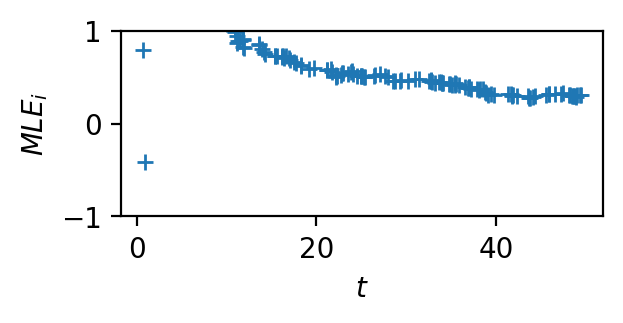

In [41]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConjMu"][k]
# mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots()
# ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
# )

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.set_ylim(-1, 1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
fig.savefig("graphics-output/TMP-mu_N1.png", dpi=1500)

(51, 100)
51


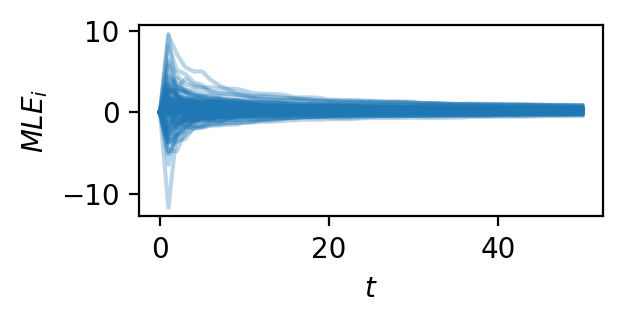

In [42]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
print(len(x))
fig, ax = plt.subplots()
for i, mu in enumerate(mu_arr.T):
    ax.plot(x, mu, alpha=0.3, label=f"$\mu_{i}$", color="tab:blue")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
# ax.set_ylim(-100, 100)
# ax.set_yscale("log")
# ax.loglog()
# ax.legend()
fig.savefig("./graphics-output/TMP-mu_nodes.png", dpi=1500)

#### Data analysis 2

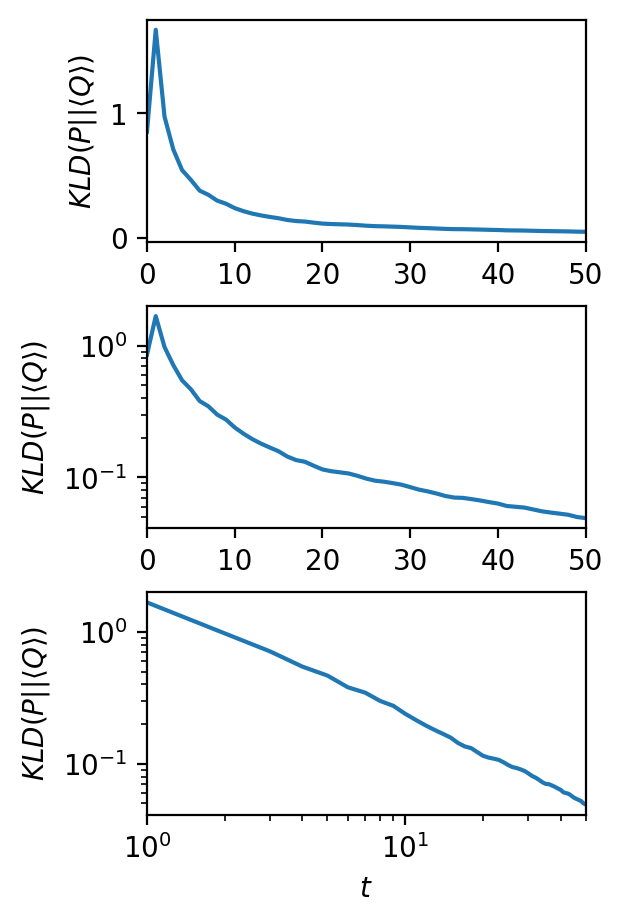

In [43]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(3, 4.5))
x = input["t_sample"] * np.arange(0, kld.shape[0])
for i, _ in enumerate(ax):
    ax[i].plot(
        x,  # input["t_sample"] * np.arange(0, kld.shape[0]),
        kld.mean(axis=1),
        label="$KLD_i$",
    )
    ax[i].set_ylabel(r"$KLD(P||\langle Q \rangle )$")
    ax[i].set_xlim(0, x[-1])
ax[2].set_xlabel("$t$")
ax[1].set_yscale("log")
ax[2].loglog()
ax[2].set_xlim(input["t_sample"], input["t_max"])
fig.savefig("./graphics-output/TMP-KLD.png", dpi=1500)

(51, 100)


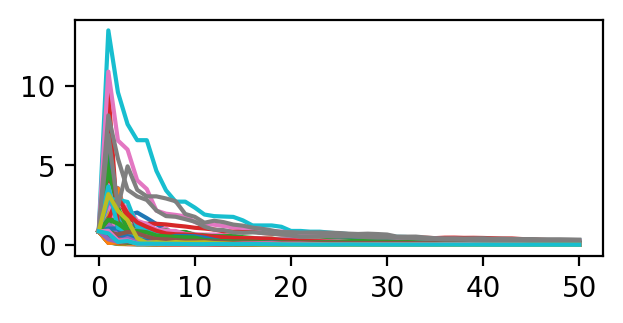

In [44]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
print(kld.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i, _ in enumerate(kld.T):
    ax.plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld[:, i],
        label="avg",
    )
# plt.loglog()
# plt.ylim(0, 2)